In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split

/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Loading MNIST dataset
X, y = load_digits(return_X_y=True)

In [3]:
#Apply stratified sampling
X_train ,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.7,random_state = 1)

In [4]:
"""Hyper-parameters"""
batch_size = 300            # Batch size for stochastic gradient descent
test_size = batch_size      # Temporary heuristic. In future we'd like to decouple testing from batching
num_centr = 150             # Number of "hidden neurons" that is number of centroids
max_iterations = 1000       # Max number of iterations
learning_rate = 5e-2        # Learning rate
num_classes = 10            # Number of target classes, 10 for MNIST
var_rbf = 225               # What variance do you expect workable for the RBF?

#Obtain and proclaim sizes
N,D = X_train.shape         
Ntest = X_test.shape[0]
print('We have %s observations with %s dimensions'%(N,D))

#Proclaim the epochs
epochs = np.floor(batch_size*max_iterations / N)
print('Train with approximately %d epochs' %(epochs))

We have 1257 observations with 64 dimensions
Train with approximately 238 epochs


In [5]:
#Placeholders for data
x = tf.placeholder('float',shape=[batch_size,D],name='input_data')
y_ = tf.placeholder(tf.int64, shape=[batch_size], name = 'Ground_truth')

In [6]:
with tf.name_scope("Hidden_layer") as scope:
  #Centroids and var are the main trainable parameters of the first layer
    centroids = tf.Variable(tf.random_uniform([num_centr,D],dtype=tf.float32),name='centroids')
    var = tf.Variable(tf.truncated_normal([num_centr],mean=var_rbf,stddev=5,dtype=tf.float32),name='RBF_variance')
  
  #For now, we collect the distances
    exp_list = []
    for i in range(num_centr):
        exp_list.append(tf.exp((-1*tf.reduce_sum(tf.square(tf.subtract(x,centroids[i,:])),1))/(2*var[i])))
        phi = tf.transpose(tf.stack(exp_list))
        
with tf.name_scope("Output_layer") as scope:
    w = tf.Variable(tf.truncated_normal([num_centr,num_classes], stddev=0.1, dtype=tf.float32),name='weight')
    bias = tf.Variable( tf.constant(0.1, shape=[num_classes]),name='bias')
        
    h = tf.matmul(phi,w)+bias
    size2 = tf.shape(h)

with tf.name_scope("Softmax") as scope:
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h,labels=y_)
    cost = tf.reduce_sum(loss)
    loss_summ = tf.summary.scalar("cross entropy_loss", cost)

INFO:tensorflow:Summary name cross entropy_loss is illegal; using cross_entropy_loss instead.


In [7]:
with tf.name_scope("train") as scope:
    tvars = tf.trainable_variables()
    #We clip the gradients to prevent explosion
    grads = tf.gradients(cost, tvars)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = zip(grads, tvars)
    train_step = optimizer.apply_gradients(gradients)
#     The following block plots for every trainable variable
    numel = tf.constant([[0]])
    for gradient, variable in gradients:
        if isinstance(gradient, ops.IndexedSlices):
            grad_values = gradient.values
        else:
            grad_values = gradient
        numel += tf.reduce_sum(tf.size(variable))
        h1 = tf.histogram_summary(variable.name, variable)
        h2 = tf.histogram_summary(variable.name + "/gradients", grad_values)
        h3 = tf.histogram_summary(variable.name + "/gradient_norm", clip_ops.global_norm([grad_values]))
with tf.name_scope("Evaluating") as scope:
    correct_prediction = tf.equal(tf.argmax(h,1), y_)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accuracy_summary = tf.summary.scalar("accuracy", accuracy)
    
merged = tf.summary.merge_all()


perf_collect = np.zeros((4,int(np.floor(max_iterations /100))))

In [8]:
#Begin Training
with tf.Session() as sess:
    with tf.device("/cpu:0"):
        print('Start session')
        writer = tf.summary.FileWriter("./log_tb", sess.graph_def)

        step = 0
        sess.run(tf.initialize_all_variables())
  
    for i in range(max_iterations):
        batch_ind = np.random.choice(N,batch_size,replace=False)
        if i%100 == 1:
            #Measure train performance
            result = sess.run([cost,accuracy,train_step],feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind]})
            perf_collect[0,step] = result[0]
            perf_collect[2,step] = result[1]
            
            #Measure test performance
            test_ind = np.random.choice(Ntest,test_size,replace=False)
            result = sess.run([cost,accuracy,merged], feed_dict={ x: X_test[test_ind], y_: y_test[test_ind]})
            perf_collect[1,step] = result[0]
            perf_collect[3,step] = result[1]
      
            #Write information for Tensorboard
            summary_str = result[2]
            writer.add_summary(summary_str, i)
            writer.flush()  #Don't forget this command! It makes sure Python writes the summaries to the log-file
        
            #Print intermediate numbers to terminal
            acc = result[1]
            print("Estimated accuracy at iteration %s of %s: %s" % (i,max_iterations, acc))
            step += 1
        else:
            sess.run(train_step,feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind]})

Start session
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Estimated accuracy at iteration 1 of 1000: 0.12
Estimated accuracy at iteration 101 of 1000: 0.79
Estimated accuracy at iteration 201 of 1000: 0.96
Estimated accuracy at iteration 301 of 1000: 0.97
Estimated accuracy at iteration 401 of 1000: 0.966667
Estimated accuracy at iteration 501 of 1000: 0.966667
Estimated accuracy at iteration 601 of 1000: 0.976667
Estimated accuracy at iteration 701 of 1000: 0.986667
Estimated accuracy at iteration 801 of 1000: 0.973333
Estimated accuracy at iteration 901 of 1000: 0.976667


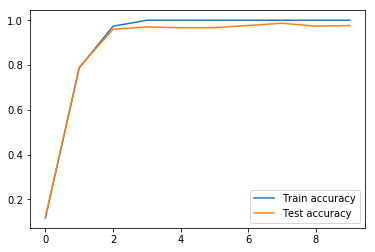

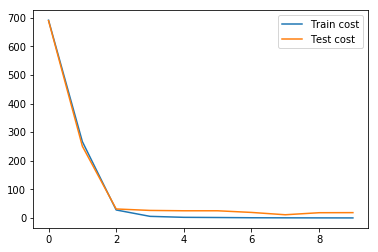

In [9]:
"""Additional plots"""
plt.figure()
plt.plot(perf_collect[2],label = 'Train accuracy')
plt.plot(perf_collect[3],label = 'Test accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(perf_collect[0],label = 'Train cost')
plt.plot(perf_collect[1],label = 'Test cost')
plt.legend()
plt.show()

### Changing the number of teh hidden later

In [10]:
num_centr = 300

In [11]:
with tf.name_scope("Hidden_layer") as scope:
  #Centroids and var are the main trainable parameters of the first layer
    centroids = tf.Variable(tf.random_uniform([num_centr,D],dtype=tf.float32),name='centroids')
    var = tf.Variable(tf.truncated_normal([num_centr],mean=var_rbf,stddev=5,dtype=tf.float32),name='RBF_variance')
  
  #For now, we collect the distances
    exp_list = []
    for i in range(num_centr):
        exp_list.append(tf.exp((-1*tf.reduce_sum(tf.square(tf.subtract(x,centroids[i,:])),1))/(2*var[i])))
        phi = tf.transpose(tf.stack(exp_list))
        
with tf.name_scope("Output_layer") as scope:
    w = tf.Variable(tf.truncated_normal([num_centr,num_classes], stddev=0.1, dtype=tf.float32),name='weight')
    bias = tf.Variable( tf.constant(0.1, shape=[num_classes]),name='bias')
    
    h = tf.matmul(phi,w)+bias
    size2 = tf.shape(h)

with tf.name_scope("Softmax") as scope:
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h,labels=y_)
    cost = tf.reduce_sum(loss)
    loss_summ = tf.summary.scalar("cross entropy_loss", cost)

INFO:tensorflow:Summary name cross entropy_loss is illegal; using cross_entropy_loss instead.


In [12]:
with tf.name_scope("train") as scope:
    tvars = tf.trainable_variables()
    #We clip the gradients to prevent explosion
    grads = tf.gradients(cost, tvars)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = zip(grads, tvars)
    train_step = optimizer.apply_gradients(gradients)
#     The following block plots for every trainable variable

    numel = tf.constant([[0]])
    for gradient, variable in gradients:
        if isinstance(gradient, ops.IndexedSlices):
            grad_values = gradient.values
        else:
            grad_values = gradient
        numel += tf.reduce_sum(tf.size(variable))
        h1 = tf.histogram_summary(variable.name, variable)
        h2 = tf.histogram_summary(variable.name + "/gradients", grad_values)
        h3 = tf.histogram_summary(variable.name + "/gradient_norm", clip_ops.global_norm([grad_values]))
with tf.name_scope("Evaluating") as scope:
    correct_prediction = tf.equal(tf.argmax(h,1), y_)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accuracy_summary = tf.summary.scalar("accuracy", accuracy)
    
merged = tf.summary.merge_all()


# For now, we collect performances in a Numpy array.
# In future releases, I hope TensorBoard allows for more
# flexibility in plotting
perf_collect = np.zeros((4,int(np.floor(max_iterations /100))))

In [13]:
#Begin Training
with tf.Session() as sess:
    with tf.device("/cpu:0"):
        print('Start session')
        writer = tf.summary.FileWriter("./log_tb", sess.graph_def)

        step = 0
        sess.run(tf.initialize_all_variables())
    
#    #Debugging
#    batch_ind = np.random.choice(N,batch_size,replace=False)
#    result = sess.run([phi],feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind]})
#    print(result[0])
    
    
    for i in range(max_iterations):
        batch_ind = np.random.choice(N,batch_size,replace=False)
        if i%100 == 1:
            #Measure train performance
            result = sess.run([cost,accuracy,train_step],feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind]})
            perf_collect[0,step] = result[0]
            perf_collect[2,step] = result[1]
            
            #Measure test performance
            test_ind = np.random.choice(Ntest,test_size,replace=False)
            result = sess.run([cost,accuracy,merged], feed_dict={ x: X_test[test_ind], y_: y_test[test_ind]})
            perf_collect[1,step] = result[0]
            perf_collect[3,step] = result[1]
      
            #Write information for Tensorboard
            summary_str = result[2]
            writer.add_summary(summary_str, i)
            writer.flush()  #Don't forget this command! It makes sure Python writes the summaries to the log-file
            
            #Print intermediate numbers to terminal
            acc = result[1]
            print("Estimated accuracy at iteration %s of %s: %s" % (i,max_iterations, acc))
            step += 1
        else:
            sess.run(train_step,feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind]})

Start session
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Estimated accuracy at iteration 1 of 1000: 0.12
Estimated accuracy at iteration 101 of 1000: 0.803333
Estimated accuracy at iteration 201 of 1000: 0.97
Estimated accuracy at iteration 301 of 1000: 0.976667
Estimated accuracy at iteration 401 of 1000: 0.963333
Estimated accuracy at iteration 501 of 1000: 0.963333
Estimated accuracy at iteration 601 of 1000: 0.956667
Estimated accuracy at iteration 701 of 1000: 0.983333
Estimated accuracy at iteration 801 of 1000: 0.97
Estimated accuracy at iteration 901 of 1000: 0.973333


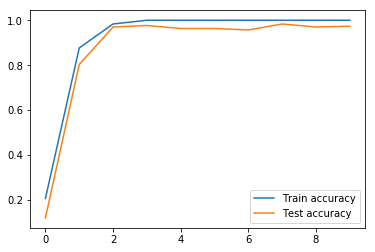

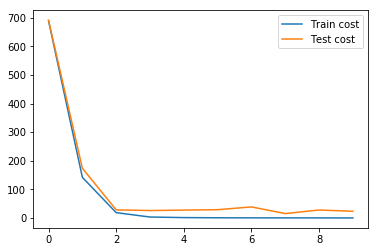

In [14]:
"""Additional plots"""
plt.figure()
plt.plot(perf_collect[2],label = 'Train accuracy')
plt.plot(perf_collect[3],label = 'Test accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(perf_collect[0],label = 'Train cost')
plt.plot(perf_collect[1],label = 'Test cost')
plt.legend()
plt.show()

### Adding a dropout

In [15]:
with tf.name_scope("Hidden_layer") as scope:
  #Centroids and var are the main trainable parameters of the first layer
    centroids = tf.Variable(tf.random_uniform([num_centr,D],dtype=tf.float32),name='centroids')
    var = tf.Variable(tf.truncated_normal([num_centr],mean=var_rbf,stddev=5,dtype=tf.float32),name='RBF_variance')
  
  #For now, we collect the distances
    exp_list = []
    for i in range(num_centr):
        exp_list.append(tf.exp((-1*tf.reduce_sum(tf.square(tf.subtract(x,centroids[i,:])),1))/(2*var[i])))
        phi = tf.transpose(tf.stack(exp_list))
        
with tf.name_scope("Output_layer") as scope:
    w = tf.Variable(tf.truncated_normal([num_centr,num_classes], stddev=0.1, dtype=tf.float32),name='weight')
    bias = tf.Variable( tf.constant(0.1, shape=[num_classes]),name='bias')
    
    h = tf.matmul(phi,w)+bias
    #Adding dropout
    h = tf.nn.dropout(h, 0.5) 
    
    size2 = tf.shape(h)

with tf.name_scope("Softmax") as scope:
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h,labels=y_)
    cost = tf.reduce_sum(loss)
    loss_summ = tf.summary.scalar("cross entropy_loss", cost)

INFO:tensorflow:Summary name cross entropy_loss is illegal; using cross_entropy_loss instead.


In [16]:
with tf.name_scope("train") as scope:
    tvars = tf.trainable_variables()
    #We clip the gradients to prevent explosion
    grads = tf.gradients(cost, tvars)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = zip(grads, tvars)
    train_step = optimizer.apply_gradients(gradients)
#     The following block plots for every trainable variable

    numel = tf.constant([[0]])
    for gradient, variable in gradients:
        if isinstance(gradient, ops.IndexedSlices):
            grad_values = gradient.values
        else:
            grad_values = gradient
        numel += tf.reduce_sum(tf.size(variable))
        h1 = tf.histogram_summary(variable.name, variable)
        h2 = tf.histogram_summary(variable.name + "/gradients", grad_values)
        h3 = tf.histogram_summary(variable.name + "/gradient_norm", clip_ops.global_norm([grad_values]))
with tf.name_scope("Evaluating") as scope:
    correct_prediction = tf.equal(tf.argmax(h,1), y_)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accuracy_summary = tf.summary.scalar("accuracy", accuracy)
    
merged = tf.summary.merge_all()

perf_collect = np.zeros((4,int(np.floor(max_iterations /100))))

In [17]:
#Begin Training
with tf.Session() as sess:
    with tf.device("/cpu:0"):
        print('Start session')
        writer = tf.summary.FileWriter("./log_tb", sess.graph_def)

        step = 0
        sess.run(tf.initialize_all_variables())
   
    for i in range(max_iterations):
        batch_ind = np.random.choice(N,batch_size,replace=False)
        if i%100 == 1:
            #Measure train performance
            result = sess.run([cost,accuracy,train_step],feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind]})
            perf_collect[0,step] = result[0]
            perf_collect[2,step] = result[1]
            
            #Measure test performance
            test_ind = np.random.choice(Ntest,test_size,replace=False)
            result = sess.run([cost,accuracy,merged], feed_dict={ x: X_test[test_ind], y_: y_test[test_ind]})
            perf_collect[1,step] = result[0]
            perf_collect[3,step] = result[1]
      
            #Write information for Tensorboard
            summary_str = result[2]
            writer.add_summary(summary_str, i)
            writer.flush()  #Don't forget this command! It makes sure Python writes the summaries to the log-file
        
            #Print intermediate numbers to terminal
            acc = result[1]
            print("Estimated accuracy at iteration %s of %s: %s" % (i,max_iterations, acc))
            step += 1
        else:
            sess.run(train_step,feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind]})

Start session
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Estimated accuracy at iteration 1 of 1000: 0.09
Estimated accuracy at iteration 101 of 1000: 0.47
Estimated accuracy at iteration 201 of 1000: 0.573333
Estimated accuracy at iteration 301 of 1000: 0.583333
Estimated accuracy at iteration 401 of 1000: 0.56
Estimated accuracy at iteration 501 of 1000: 0.58
Estimated accuracy at iteration 601 of 1000: 0.59
Estimated accuracy at iteration 701 of 1000: 0.573333
Estimated accuracy at iteration 801 of 1000: 0.596667
Estimated accuracy at iteration 901 of 1000: 0.593333


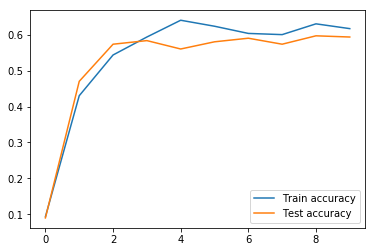

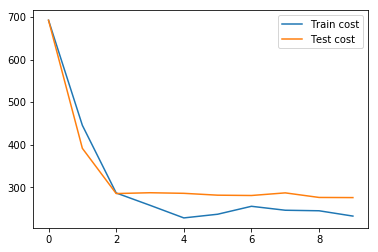

In [18]:
"""Additional plots"""
plt.figure()
plt.plot(perf_collect[2],label = 'Train accuracy')
plt.plot(perf_collect[3],label = 'Test accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(perf_collect[0],label = 'Train cost')
plt.plot(perf_collect[1],label = 'Test cost')
plt.legend()
plt.show()